<a href="https://colab.research.google.com/github/MoncefDj/AI-DS-Masters/blob/main/TP_DL_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 02 Deep learning

In [ ]:
pip install gdown rarfile

## Downloading and extracting the dataset

In [ ]:
import gdown
import rarfile
import os
from PIL import Image

# Step 1: Download the dataset
file_id = "1fcjl1VVzYFMdrXp6srErJjLWsr8Y0HUY"
download_url = f"https://drive.google.com/uc?id={file_id}"
rar_path = "awe_dataset.rar"  # The file will be saved with this name

# Download the file
print("Downloading dataset...")
gdown.download(download_url, rar_path, quiet=False)
print("Download completed.")

# Step 2: Extract the .rar file
extract_path = ""
try:
    with rarfile.RarFile(rar_path) as rf:
        rf.extractall(extract_path)
    print("Dataset extracted successfully.")
except rarfile.Error as e:
    print(f"Error extracting rar file: {e}")

Downloading...
From (original): https://drive.google.com/uc?id=1fcjl1VVzYFMdrXp6srErJjLWsr8Y0HUY
From (redirected): https://drive.google.com/uc?id=1fcjl1VVzYFMdrXp6srErJjLWsr8Y0HUY&confirm=t&uuid=74820b33-8a17-4780-bcc2-a10f2afb6cba
To: /content/awe_dataset.rar
100%|██████████| 30.4M/30.4M [00:00<00:00, 93.7MB/s]


Download completed.
Dataset extracted successfully.


In [ ]:
# Import required libraries
import os                     # For operating system dependent functionality
import numpy as np           # For numerical operations
import random               # For random sampling
from PIL import Image       # For image processing
import json                 # For JSON file handling
import matplotlib.pyplot as plt  # For plotting

## Dataset Configuration

In [ ]:
# Define dataset path
dataset_path = "awe"  # Replace with your actual dataset path

# Define constants
TARGET_SIZE = (128, 128)  # Target size for image resizing
IMAGES_PER_FOLDER = 10    # Number of images in each folder

## Dataset Loading Function

In [ ]:
def load_dataset_with_annotations(dataset_path, target_size=TARGET_SIZE):
    """
    Load dataset images and annotations into a flattened tensor.

    Args:
        dataset_path (str): Path to the dataset directory
        target_size (tuple): Target size for image resizing (width, height)

    Returns:
        tuple: (tensor, annotations, folders)
            - tensor: numpy array of shape (num_folders, images_per_folder, flattened_size)
            - annotations: dictionary containing image annotations
            - folders: list of folder names
    """
    # Get sorted list of folders
    folders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
    num_folders = len(folders)

    # Calculate flattened size for the target size
    flattened_size = target_size[0] * target_size[1] * 3  # 3 for RGB channels

    # Initialize tensor and annotations dictionary
    tensor = np.zeros((num_folders, IMAGES_PER_FOLDER, flattened_size), dtype=np.uint8)
    annotations = {}

    # Iterate through folders and images
    for folder_idx, folder in enumerate(folders):
        folder_path = os.path.join(dataset_path, folder)

        # Load annotations from JSON
        annotation_path = os.path.join(folder_path, "annotations.json")
        with open(annotation_path, 'r') as f:
            annotations_data = json.load(f)
        annotations[folder] = annotations_data["data"]

        # Load images
        for img_idx in range(IMAGES_PER_FOLDER):
            img_file = f"{str(img_idx + 1).zfill(2)}.png"
            img_path = os.path.join(folder_path, img_file)

            if os.path.exists(img_path):
                img = Image.open(img_path).convert("RGB")
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                tensor[folder_idx, img_idx] = np.array(img).flatten()
            else:
                print(f"Image not found: {img_path}")

    return tensor, annotations, folders

## Load Dataset

In [ ]:
# Load dataset with images and annotations
dataset_tensor, annotations, folders = load_dataset_with_annotations(dataset_path)

## Display Function

In [ ]:
def display_random_images_with_annotations_and_index(dataset_tensor, annotations, folders, num_images=10):
    """
    Display random images from the dataset with their annotations.

    Args:
        dataset_tensor (numpy.ndarray): Tensor containing image data
        annotations (dict): Dictionary containing image annotations
        folders (list): List of folder names
        num_images (int): Number of random images to display
    """
    num_folders, num_images_per_folder, _ = dataset_tensor.shape

    # Randomly sample images
    sampled_indices = random.sample(range(num_folders * num_images_per_folder), num_images)

    plt.figure(figsize=(12, 12))

    for i, idx in enumerate(sampled_indices):
        folder_idx = idx // num_images_per_folder
        img_idx = idx % num_images_per_folder

        # Get image data and reshape
        image_data = dataset_tensor[folder_idx, img_idx].reshape((128, 128, 3))

        # Get annotations
        folder = str(folder_idx + 1).zfill(3)
        image_info = annotations[folder].get(f"{str(img_idx + 1).zfill(2)}")

        # Display image
        plt.subplot(5, 2, i + 1)
        plt.imshow(image_data)
        plt.axis('off')

        # Create annotation text
        annotation_text = (
            f"Testing Set\nIndex: {str(idx).zfill(4)}\n"
            f"Folder: {folder}\n"
            f"file: {image_info['file']}\n"
            f"x: {image_info['x']}\n"
            f"y: {image_info['y']}\n"
            f"w: {image_info['w']}\n"
            f"h: {image_info['h']}\n"
            f"d: {image_info['d']}\n"
            f"accessories: {image_info['accessories']}\n"
            f"overlap: {image_info['overlap']}\n"
            f"hYaw: {image_info['hYaw']}"
        )

        plt.title(annotation_text, fontsize=8)

    plt.tight_layout()
    plt.show()

## Display Random Images

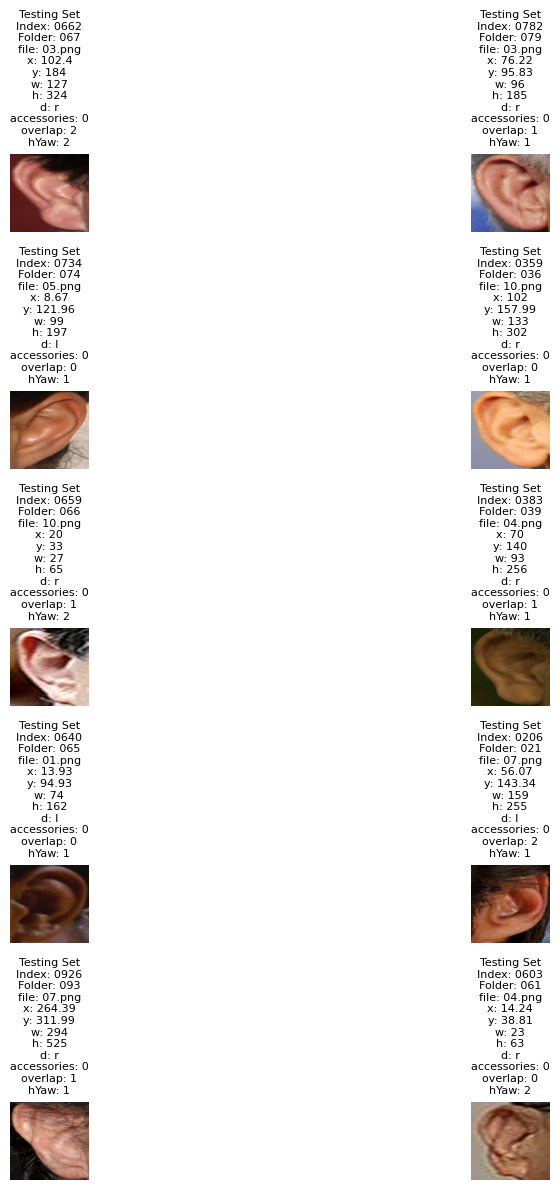

In [ ]:
# Display 10 random images with annotations
display_random_images_with_annotations_and_index(dataset_tensor, annotations, folders)

## Load Split Indices Function

In [ ]:
def load_split_indices(file_path):
    """
    Load and parse indices from a text file.

    Args:
        file_path (str): Path to the text file containing indices

    Returns:
        list: List of integers representing indices
    """
    with open(file_path, 'r') as f:
        return [int(x) for x in f.read().strip().split()]

## Dataset Splitting Function

In [ ]:
def split_dataset(dataset_tensor, annotations, folders,
                 train_file='/content/awe/train.txt',
                 test_file='/content/awe/test.txt'):
    """
    Split the dataset into training and testing sets based on provided index files.

    Args:
        dataset_tensor (numpy.ndarray): The complete dataset tensor
        annotations (dict): Dictionary containing image annotations
        folders (list): List of folder names
        train_file (str): Path to file containing training indices
        test_file (str): Path to file containing testing indices

    Returns:
        tuple: (X_train, X_test, train_annotations, test_annotations, train_indices, test_indices)
            - X_train: Training data tensor
            - X_test: Testing data tensor
            - train_annotations: Dictionary of training annotations
            - test_annotations: Dictionary of testing annotations
            - train_indices: List of training indices
            - test_indices: List of testing indices
    """
    # Load indices from files
    train_indices = load_split_indices(train_file)
    test_indices = load_split_indices(test_file)

    num_folders = dataset_tensor.shape[0]
    num_images_per_folder = dataset_tensor.shape[1]

    def index_to_folder_image(index):
        """Convert global index to folder and image indices."""
        folder_idx = (index - 1) // num_images_per_folder
        image_idx = (index - 1) % num_images_per_folder
        return folder_idx, image_idx

    # Convert indices to (folder_idx, image_idx) pairs
    train_tensor_indices = [index_to_folder_image(idx) for idx in train_indices]
    test_tensor_indices = [index_to_folder_image(idx) for idx in test_indices]

    # Create training and testing tensors
    X_train = np.array([dataset_tensor[fold_idx, img_idx]
                       for fold_idx, img_idx in train_tensor_indices])
    X_test = np.array([dataset_tensor[fold_idx, img_idx]
                      for fold_idx, img_idx in test_tensor_indices])

    # Extract unique folder indices
    train_folder_indices = set(idx[0] for idx in train_tensor_indices)
    test_folder_indices = set(idx[0] for idx in test_tensor_indices)

    # Create annotation dictionaries for train and test sets
    train_annotations = {folders[fold_idx]: annotations[folders[fold_idx]]
                        for fold_idx in train_folder_indices}
    test_annotations = {folders[fold_idx]: annotations[folders[fold_idx]]
                       for fold_idx in test_folder_indices}

    print("\nDataset split summary:")
    print(f"Training indices: {train_indices}")
    print(f"Testing indices: {test_indices}")

    return (X_train, X_test, train_annotations, test_annotations,
            train_indices, test_indices)

## Execute Dataset Split

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, train_annotations, test_annotations, train_indices, test_indices = split_dataset(
    dataset_tensor,
    annotations,
    folders
)

# Display resulting dataset shapes
print(f"\nFinal dataset shapes:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Dataset split summary:
Training indices: [48, 49, 43, 46, 429, 423, 422, 110, 105, 103, 150, 149, 242, 248, 246, 244, 775, 776, 779, 772, 488, 483, 485, 1000, 991, 999, 996, 742, 748, 744, 750, 632, 631, 637, 638, 402, 404, 408, 884, 889, 885, 875, 878, 877, 232, 238, 239, 234, 382, 388, 381, 357, 351, 355, 629, 627, 630, 299, 295, 300, 293, 305, 308, 306, 512, 513, 511, 700, 697, 694, 454, 455, 457, 586, 589, 588, 643, 641, 645, 986, 984, 985, 34, 31, 37, 32, 893, 896, 894, 349, 343, 342, 565, 570, 62, 70, 68, 269, 270, 265, 944, 947, 946, 933, 935, 932, 843, 846, 841, 753, 754, 756, 313, 312, 317, 220, 215, 211, 380, 374, 379, 338, 332, 333, 94, 91, 96, 366, 363, 367, 726, 721, 728, 19, 17, 12, 398, 392, 391, 470, 468, 464, 465, 159, 152, 155, 854, 858, 851, 856, 497, 500, 499, 555, 551, 552, 768, 764, 901, 905, 902, 910, 803, 806, 809, 56, 54, 57, 55, 792, 797, 793, 471, 473, 478, 476, 431, 438, 436, 703, 705, 702, 707, 226, 230, 225, 165, 161, 162, 271, 278, 280, 275, 614, 617, 61

## Function definition with documentation

In [ ]:
def display_split_random_images_with_annotations(X_train, X_test, train_indices, test_indices, dataset_tensor, annotations, num_images=5):
    """
    Display random images from training and testing sets with their annotations.

    Parameters:
    -----------
    X_train : array-like
        Training dataset
    X_test : array-like
        Testing dataset
    train_indices : list
        List of indices for training images
    test_indices : list
        List of indices for testing images
    dataset_tensor : array-like
        Tensor containing all images (shape: [num_folders, images_per_folder, height, width, channels])
    annotations : dict
        Dictionary containing annotations for all images
    num_images : int, optional (default=5)
        Number of images to display from each set

    Returns:
    --------
    None
        Displays a matplotlib figure with annotated images
    """

    plt.figure(figsize=(20, 12))

    def get_folder_image_idx(index):
        """
        Convert 1-based index to folder and image indices.

        Parameters:
        -----------
        index : int
            1-based index of the image

        Returns:
        --------
        tuple : (folder_idx, img_idx)
            0-based indices for folder and image
        """
        index = index - 1  # Convert to 0-based indexing
        folder_idx = index // 10
        img_idx = index % 10
        return folder_idx, img_idx

    # Display training images
    train_samples = random.sample(train_indices, num_images)
    for i, idx in enumerate(train_samples):
        folder_idx, img_idx = get_folder_image_idx(idx)

        # Get image data
        image_data = dataset_tensor[folder_idx, img_idx].reshape((128, 128, 3))

        # Get corresponding annotations
        folder = str(folder_idx + 1).zfill(3)
        image_info = annotations[folder].get(f"{str(img_idx + 1).zfill(2)}")

        # Display the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_data)
        plt.axis('off')

        # Display annotation information
        annotation_text = f"Testing Set\nIndex: {str(idx).zfill(4)}\n"
        annotation_text += f"Folder: {folder}\n"
        annotation_text += f"file: {image_info['file']}\n"
        annotation_text += f"x: {image_info['x']}\n"
        annotation_text += f"y: {image_info['y']}\n"
        annotation_text += f"w: {image_info['w']}\n"
        annotation_text += f"h: {image_info['h']}\n"
        annotation_text += f"d: {image_info['d']}\n"
        annotation_text += f"accessories: {image_info['accessories']}\n"
        annotation_text += f"overlap: {image_info['overlap']}\n"
        annotation_text += f"hYaw: {image_info['hYaw']}"

        plt.title(annotation_text, fontsize=8)

    # Display testing images
    test_samples = random.sample(test_indices, num_images)
    for i, idx in enumerate(test_samples):
        folder_idx, img_idx = get_folder_image_idx(idx)

        # Get image data
        image_data = dataset_tensor[folder_idx, img_idx].reshape((128, 128, 3))

        # Get corresponding annotations
        folder = str(folder_idx + 1).zfill(3)
        image_info = annotations[folder].get(f"{str(img_idx + 1).zfill(2)}")

        # Display the image
        plt.subplot(2, 5, i + num_images + 1)
        plt.imshow(image_data)
        plt.axis('off')

        # Display annotation information
        annotation_text = f"Testing Set\nIndex: {str(idx).zfill(4)}\n"
        annotation_text += f"Folder: {folder}\n"
        annotation_text += f"file: {image_info['file']}\n"
        annotation_text += f"x: {image_info['x']}\n"
        annotation_text += f"y: {image_info['y']}\n"
        annotation_text += f"w: {image_info['w']}\n"
        annotation_text += f"h: {image_info['h']}\n"
        annotation_text += f"d: {image_info['d']}\n"
        annotation_text += f"accessories: {image_info['accessories']}\n"
        annotation_text += f"overlap: {image_info['overlap']}\n"
        annotation_text += f"hYaw: {image_info['hYaw']}"

        plt.title(annotation_text, fontsize=8)

    plt.tight_layout()
    plt.show()

## Function call

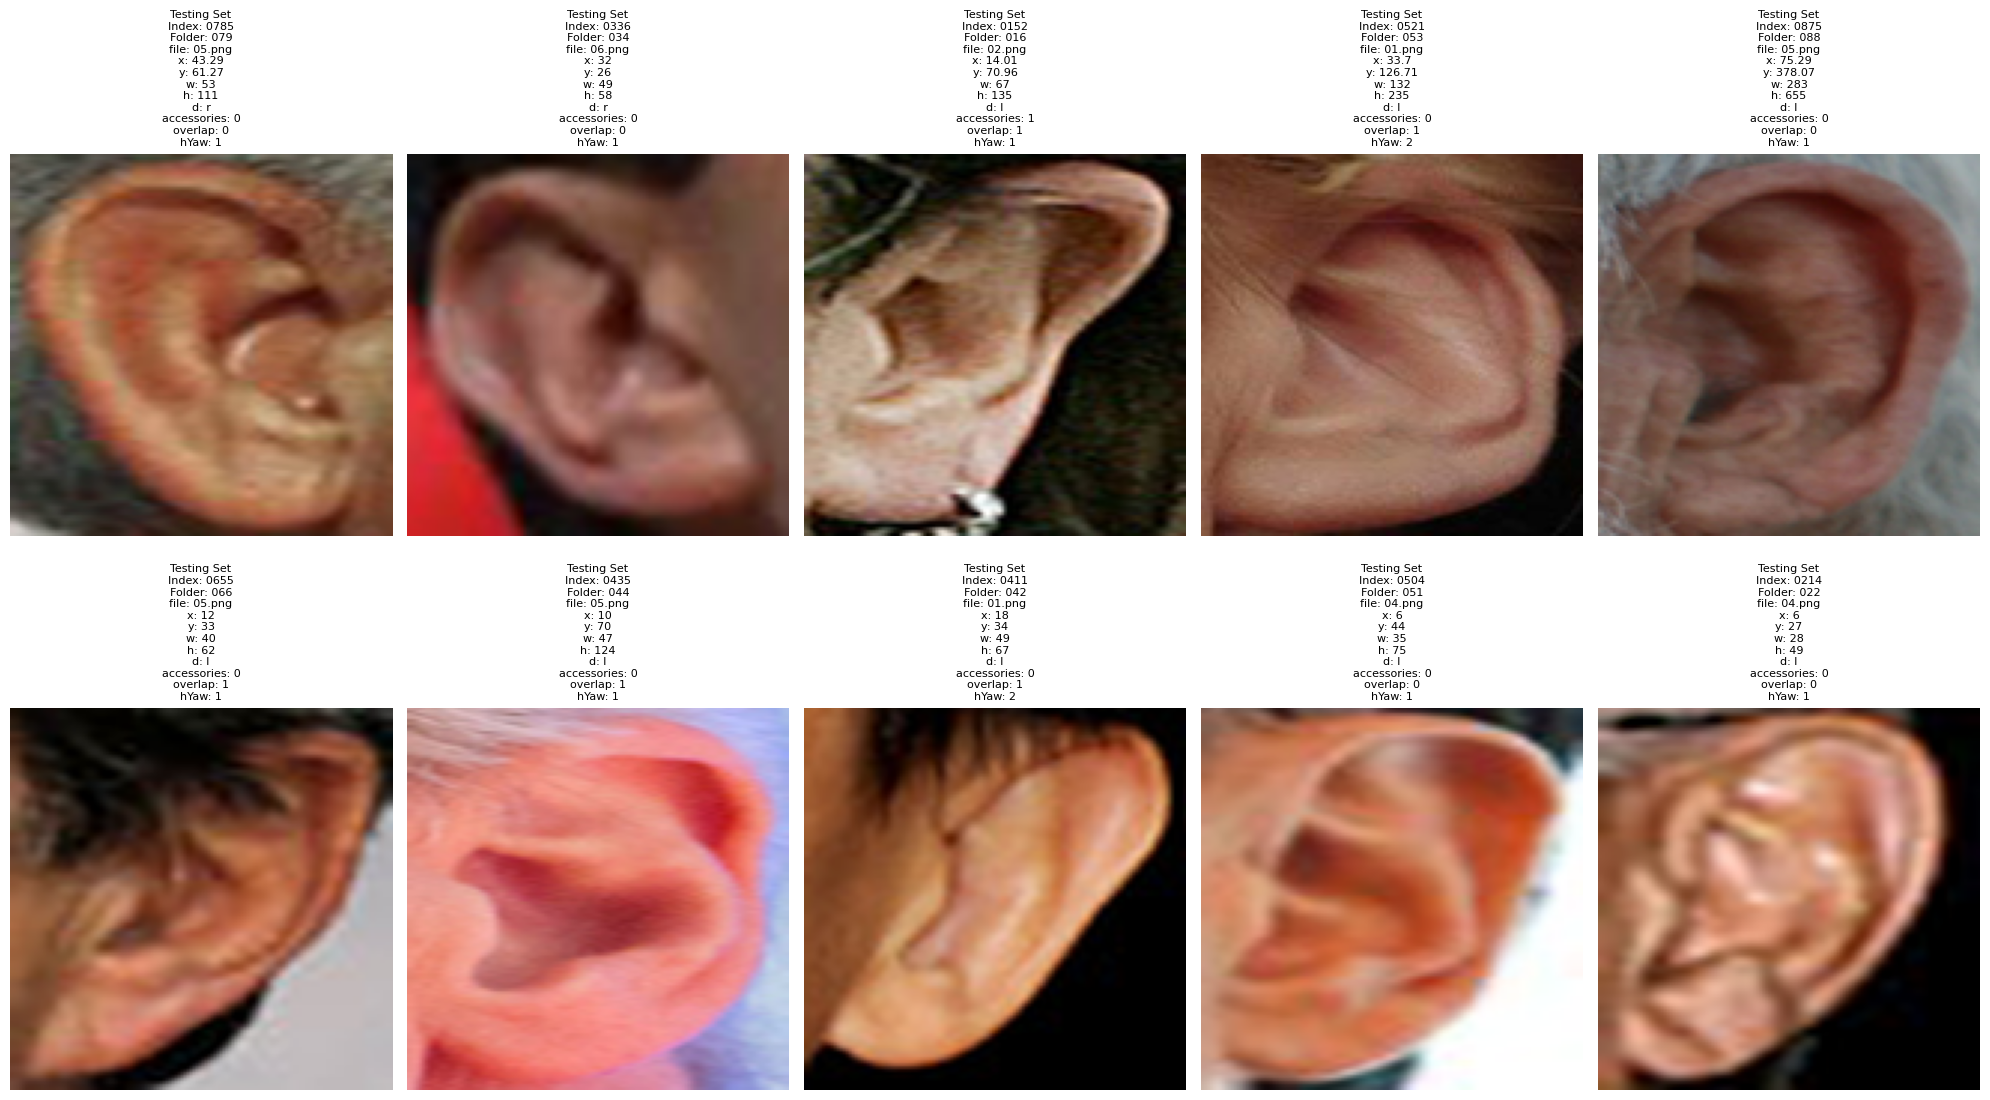

In [ ]:
# Display random images with annotations from both sets
display_split_random_images_with_annotations(
    X_train,
    X_test,
    train_indices,
    test_indices,
    dataset_tensor,
    annotations
)

## Derive y_train and y_test

In [ ]:
# Derive folder names from indices
def derive_labels(indices, dataset_tensor):
    """
    Derive labels (folder indices) from global image indices.

    Args:
        indices (list): Global indices (1-based) for images.
        dataset_tensor (numpy.ndarray): Dataset tensor with shape [folders, images_per_folder, ...]

    Returns:
        list: Derived folder indices corresponding to the input indices.
    """
    num_images_per_folder = dataset_tensor.shape[1]

    # Compute folder labels from global indices
    labels = [(index - 1) // num_images_per_folder for index in indices]
    return labels

# Derive y_train and y_test
y_train = derive_labels(train_indices, dataset_tensor)
y_test = derive_labels(test_indices, dataset_tensor)

# Print the number of unique classes in y_train and y_test
print(f"Number of unique folders in training set: {len(set(y_train))}")
print(f"Number of unique folders in testing set: {len(set(y_test))}")


Number of unique folders in training set: 100
Number of unique folders in testing set: 100


## Encode Labels into Categorical Format

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical format
num_classes = len(folders)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Print shapes
print(f"y_train shape (categorical): {y_train_categorical.shape}")
print(f"y_test shape (categorical): {y_test_categorical.shape}")


y_train shape (categorical): (600, 100)
y_test shape (categorical): (400, 100)


## Normalize Training and Testing Data

In [ ]:
# Normalize the image tensors
X_train = X_train / 255.0
X_test = X_test / 255.0

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (600, 49152)
X_test shape: (400, 49152)


# ==========================================================================================================================================================================================================================================

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Define and Train the EfficientNet Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Define the EfficientNet model
def build_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Build and compile the model
input_shape = (128, 128, 3)
model = build_efficientnet_model(input_shape, num_classes=num_classes)

# Reshape X_train and X_test to the correct shape for EfficientNet
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)

# Normalize the image tensors
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verify the shapes
print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, 128, 128, 3)
print(f"X_test shape: {X_test.shape}")    # Expected: (num_samples, 128, 128, 3)

# Train the model
history = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=10,
    batch_size=32
)


X_train shape: (600, 128, 128, 3)
X_test shape: (400, 128, 128, 3)
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.0067 - loss: 4.6721 - val_accuracy: 0.0100 - val_loss: 4.6773
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1093 - loss: 4.2471 - val_accuracy: 0.0100 - val_loss: 4.7055
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.2935 - loss: 3.4407 - val_accuracy: 0.0100 - val_loss: 4.7057
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6085 - loss: 2.3469 - val_accuracy: 0.0100 - val_loss: 4.8842
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.7281 - loss: 1.4309 - val_accuracy: 0.0100 - val_loss: 4.7954
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8909 - loss: 0.7360 - val_accuracy: 0.0100 - val_loss: 4.7390
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9625 - loss: 0.3464 - val_accuracy: 0.0100 - val_loss: 5.1314
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step 

## Evaluate the Model

In [ ]:
# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 532ms/step - accuracy: 0.0083 - loss: 5.6259
Test Loss: 5.588564395904541
Test Accuracy: 0.009999999776482582


## Predict Folder for a Given Image Index

In [ ]:
def predict_folder(index, dataset_tensor, model):
    """
    Predict the folder of a given image index.

    Args:
        index (int): Global index of the image.
        dataset_tensor (numpy.ndarray): Tensor containing the dataset.
        model (Model): Trained EfficientNet model.

    Returns:
        str: Predicted folder name.
    """
    # Convert global index to folder and image indices
    num_images_per_folder = dataset_tensor.shape[1]
    folder_idx = (index - 1) // num_images_per_folder
    img_idx = (index - 1) % num_images_per_folder

    # Extract and preprocess the image
    image = dataset_tensor[folder_idx, img_idx].reshape(1, 128, 128, 3) / 255.0

    # Make prediction
    prediction = model.predict(image)
    predicted_folder_idx = np.argmax(prediction)

    return folders[predicted_folder_idx]

# Test the prediction function
test_index = 784
predicted_folder = predict_folder(test_index, dataset_tensor, model)
print(f"Image with index {test_index} belongs to folder {predicted_folder}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image with index 784 belongs to folder 061.


## Evaluate Accuracy, Specificity, and Sensitivity

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def compute_metrics(y_true, y_pred, class_names):
    """
    Compute accuracy, specificity, and sensitivity based on true and predicted values.

    Args:
        y_true (array-like): Ground truth labels (one-hot encoded or categorical).
        y_pred (array-like): Predicted labels (probabilities or categorical).
        class_names (list): List of class (folder) names.

    Returns:
        dict: A dictionary containing accuracy, specificity, and sensitivity for each class.
    """
    # Convert one-hot to categorical if needed
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Metrics
    metrics = {}
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fn = sum(cm[i, :]) - tp
        fp = sum(cm[:, i]) - tp
        tn = sum(cm.flatten()) - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics[class_name] = {
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Accuracy": (tp + tn) / cm.sum()
        }
    return metrics


## Evaluate on the Test Set

In [ ]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Class names (folder names)
class_names = folders

# Compute metrics
metrics = compute_metrics(y_test_categorical, y_test_pred, class_names)
print("Metrics for each class:")
for class_name, class_metrics in metrics.items():
    print(f"{class_name}: {class_metrics}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 684ms/step
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

         001       0.00      0.00      0.00         4
         002       0.00      0.00      0.00         4
         003       0.00      0.00      0.00         4
         004       0.00      0.00      0.00         4
         005       0.00      0.00      0.00         4
         006       0.00      0.00      0.00         4
         007       0.00      0.00      0.00         4
         008       0.00      0.00      0.00         4
         009       0.00      0.00      0.00         4
         010       0.00      0.00      0.00         4
         011       0.00      0.00      0.00         4
         012       0.00      0.00      0.00         4
         013       0.00      0.00      0.00         4
         014       0.00      0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

## Evaluate Efficiency

In [ ]:
def compute_efficiency(model):
    """
    Compute the efficiency of the model (number of parameters).

    Args:
        model (Model): Trained model.

    Returns:
        dict: A dictionary containing the number of parameters and model size.
    """
    num_params = model.count_params()  # Total trainable and non-trainable parameters
    print(f"Number of parameters in the model: {num_params}")

    return {
        "Parameters": num_params,
        "Efficiency": "Highly Efficient" if num_params < 1e6 else "Moderate Efficiency"
    }


## Evaluate the Model Efficiency

In [ ]:
# Compute efficiency metrics
efficiency_metrics = compute_efficiency(model)
print("Efficiency Metrics:")
print(efficiency_metrics)


Number of parameters in the model: 4226439
Efficiency Metrics:
{'Parameters': 4226439, 'Efficiency': 'Moderate Efficiency'}


## Report Results

In [ ]:
def report_results(metrics, efficiency_metrics):
    """
    Display the final evaluation report.

    Args:
        metrics (dict): Metrics for effectiveness (accuracy, sensitivity, specificity).
        efficiency_metrics (dict): Efficiency metrics (parameters, etc.).

    Returns:
        None
    """
    print("\nFinal Evaluation Report:\n")
    print("Effectiveness Metrics (Per Class):")
    for class_name, class_metrics in metrics.items():
        print(f"Class {class_name}:")
        for metric, value in class_metrics.items():
            print(f"  {metric}: {value:.4f}")

    print("\nEfficiency Metrics:")
    for metric, value in efficiency_metrics.items():
        print(f"{metric}: {value}")


## Call the Function

In [ ]:
report_results(metrics, efficiency_metrics)



Final Evaluation Report:

Effectiveness Metrics (Per Class):
Class 001:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 002:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 003:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 004:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 005:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 006:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 007:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 008:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 009:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 010:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 011:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 012:
  Sensitivity: 0.0000
  Specificity: 1.0000
  Accuracy: 0.9900
Class 013:
  Sensitivity: 0.0000
  Specificity: 1.

#============================================================================================================================

## Data Augmentation

## Update the Model for Fine-Tuning

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model with EfficientNetB0 and additional layers
def build_finetuned_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze earlier layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Build the model
input_shape = (128, 128, 3)
model = build_finetuned_model(input_shape, num_classes=len(folders))

# Display model summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_12 (Rescaling)  │ (None, 128, 128, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_6           │ (None, 128, 128, 3)    │              7 │ rescaling_12[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_13 (Rescaling)  │ (None, 128, 128, 3)    │              0 │ normalization_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_13[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,226,439 (16.12 MB)

 Trainable params: 176,868 (690.89 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Add Learning Rate Scheduler

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback to reduce learning rate on a plateau
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


## Train the Model

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0060 - loss: 4.6420 - val_accuracy: 0.0100 - val_loss: 4.6098 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0103 - loss: 4.6210 - val_accuracy: 0.0100 - val_loss: 4.6056 - learning_rate: 0.0010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0059 - loss: 4.6074 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0153 - loss: 4.6065 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0052 - loss: 4.6060 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0045 - loss: 4.6055 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.0066 - loss: 4.6053 - val_accuracy: 

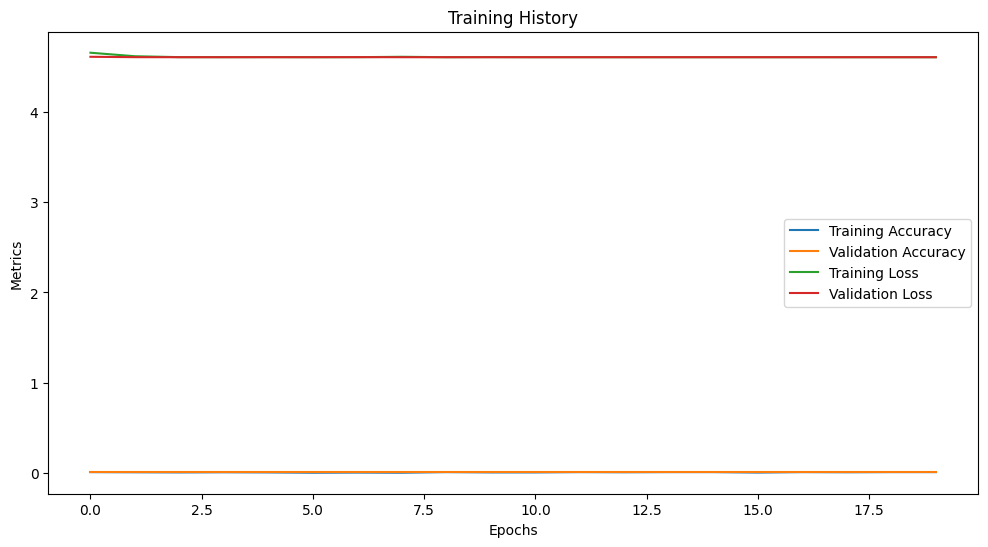

In [ ]:
# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=32),
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    callbacks=[lr_scheduler]
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training History')
plt.show()

## Fine-Tune the Model

In [ ]:
# Unfreeze some layers of the base model for fine-tuning
for layer in model.layers[:200]:  # Freeze earlier layers
    layer.trainable = False
for layer in model.layers[200:]:  # Unfreeze later layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Retrain the model
history_finetune = model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=32),
    validation_data=(X_test, y_test_categorical),
    epochs=10,
    callbacks=[lr_scheduler]
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.0054 - loss: 4.6700 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 1.0000e-04
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0183 - loss: 4.6223 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 1.0000e-04
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0133 - loss: 4.6027 - val_accuracy: 0.0100 - val_loss: 4.6052 - learning_rate: 1.0000e-04
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.0076 - loss: 4.6132 - val_accuracy: 0.0100 - val_loss: 4.6053 - learning_rate: 1.0000e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0115 - loss: 4.6081 - val_accuracy: 0.0100 - val_loss: 4.6054 - learning_rate: 1.0000e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.0060 - loss: 4.6210
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0062 - loss: 4.

## Evaluate the Model

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 609ms/step - accuracy: 0.0075 - loss: 4.6054
Test Loss: 4.60602331161499
Test Accuracy: 0.009999999776482582


## Compute Metrics (Effectiveness)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Function to compute sensitivity, specificity, and accuracy
def compute_metrics(y_true, y_pred, class_names):
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    metrics = {}
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fn = sum(cm[i, :]) - tp
        fp = sum(cm[:, i]) - tp
        tn = sum(cm.flatten()) - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics[class_name] = {
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Accuracy": (tp + tn) / cm.sum()
        }
    return metrics

# Predict on the test set
y_test_pred = model.predict(X_test)

# Compute and display metrics
metrics = compute_metrics(y_test_categorical, y_test_pred, class_names=folders)
print(metrics)


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

         001       0.00      0.00      0.00         4
         002       0.00      0.00      0.00         4
         003       0.00      0.00      0.00         4
         004       0.00      0.00      0.00         4
         005       0.00      0.00      0.00         4
         006       0.00      0.00      0.00         4
         007       0.00      0.00      0.00         4
         008       0.00      0.00      0.00         4
         009       0.00      0.00      0.00         4
         010       0.00      0.00      0.00         4
         011       0.00      0.00      0.00         4
         012       0.00      0.00      0.00         4
         013       0.00      0.00      0.00         4
         014       0.00      0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Evaluate Efficiency (Number of Parameters)

In [ ]:
# Check the number of parameters
num_params = model.count_params()
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 4226439


#==========================================================================================================


## Using ResNet50

## Define ResNet50-Based Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze initial layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

# Build ResNet50 model
input_shape = (128, 128, 3)
resnet_model = build_resnet_model(input_shape, num_classes=len(folders))

# Display model summary
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,862,884 (91.03 MB)

 Trainable params: 275,172 (1.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train the ResNet50 Model

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.0104 - loss: 4.7473 - val_accuracy: 0.0100 - val_loss: 4.6189 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.0084 - loss: 4.6349 - val_accuracy: 0.0100 - val_loss: 4.6093 - learning_rate: 0.0010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.0044 - loss: 4.6289 - val_accuracy: 0.0100 - val_loss: 4.6067 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.0087 - loss: 4.6091 - val_accuracy: 0.0100 - val_loss: 4.6064 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.0021 - loss: 4.6075 - val_accuracy: 0.0100 - val_loss: 4.6056 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.0091 - loss: 4.6064 - val_accuracy: 0.0100 - val_loss: 4.6057 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.0162 - loss: 4.6076 - val_accuracy: 0.0100 - va

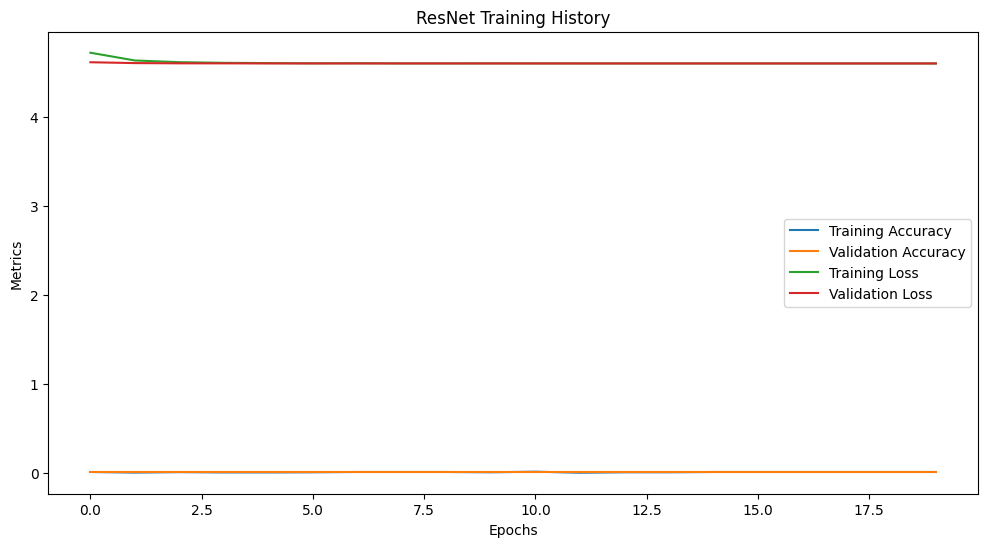

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate on plateau
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the ResNet50 model
history_resnet = resnet_model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=32),
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    callbacks=[lr_scheduler]
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('ResNet Training History')
plt.show()


## Evaluate the Model

In [ ]:
# Evaluate ResNet50 on the test set
loss, accuracy = resnet_model.evaluate(X_test, y_test_categorical)
print(f"ResNet Test Loss: {loss}")
print(f"ResNet Test Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.0083 - loss: 4.6054
ResNet Test Loss: 4.6051859855651855
ResNet Test Accuracy: 0.009999999776482582


## Fine-Tune the ResNet50 Model

In [ ]:
# Unfreeze some layers for fine-tuning
for layer in resnet_model.layers[:100]:  # Freeze initial layers
    layer.trainable = False
for layer in resnet_model.layers[100:]:  # Unfreeze later layers
    layer.trainable = True

# Recompile with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

# Fine-tune the ResNet50 model
history_finetune_resnet = resnet_model.fit(
    datagen.flow(X_train, y_train_categorical, batch_size=32),
    validation_data=(X_test, y_test_categorical),
    epochs=10,
    callbacks=[lr_scheduler]
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.0114 - loss: 4.6051 - val_accuracy: 0.0100 - val_loss: 4.6072 - learning_rate: 1.0000e-04
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.0077 - loss: 4.6053 - val_accuracy: 0.0100 - val_loss: 4.6076 - learning_rate: 1.0000e-04
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.0058 - loss: 4.6054 - val_accuracy: 0.0100 - val_loss: 4.6096 - learning_rate: 1.0000e-04
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.0129 - loss: 4.6051 - val_accuracy: 0.0100 - val_loss: 4.6108 - learning_rate: 1.0000e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 162s 8s/step - accuracy: 0.0083 - loss: 4.6053 - val_accuracy: 0.0100 - val_loss: 4.6116 - learning_rate: 1.0000e-04
Epoch 6/10
13/19 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.0153 - loss: 4.6055

KeyboardInterrupt: 

##  Re-Evaluate the Model

In [ ]:
# Re-evaluate the fine-tuned ResNet50
loss, accuracy = resnet_model.evaluate(X_test, y_test_categorical)
print(f"ResNet Fine-Tuned Test Loss: {loss}")
print(f"ResNet Fine-Tuned Test Accuracy: {accuracy}")


#===============================================================================================================================================================================================================================================

## Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    concatenate,
)
import matplotlib.pyplot as plt


## Verify and Adjust Input Data

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert y_train and y_test to NumPy arrays if they are lists
y_train = np.array(y_train)
y_test = np.array(y_test)

# Ensure X_train and X_test have the correct shape
if len(X_train.shape) == 2:  # If data is flattened (e.g., (num_samples, 128*128*3))
    X_train = X_train.reshape(-1, 128, 128, 3)  # Reshape to (num_samples, height, width, channels)
    X_test = X_test.reshape(-1, 128, 128, 3)

# Verify data types
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Ensure y_train and y_test are one-hot encoded
num_classes = len(folders)  # Replace 'folders' with the actual number of classes
if len(y_train.shape) == 1:  # If labels are not one-hot encoded
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (600, 128, 128, 3), y_train shape: (600, 100)
X_test shape: (400, 128, 128, 3), y_test shape: (400, 100)


## Define the Feature Extractor

In [ ]:
def ear_feature_extractor(input_shape):
    """
    Build the feature extractor architecture for ear images.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).

    Returns:
        Model: Keras model implementing the described architecture.
    """
    input_layer = Input(shape=input_shape)

    # Layer 1: Conv + ReLU
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(input_layer)
    x = Dropout(0.1)(x)  # 10% dropout

    # Layer 2: Conv + ReLU
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    # Layer 3: MaxPool
    x = MaxPooling2D((2, 2), strides=2)(x)

    # Layer 4: Conv + ReLU
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = Dropout(0.2)(x)  # 20% dropout

    # Layer 5: MaxPool
    x = MaxPooling2D((2, 2), strides=2)(x)

    # Layer 6: Conv + ReLU
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = Dropout(0.3)(x)  # 30% dropout

    # Layer 7: MaxPool
    x = MaxPooling2D((2, 2), strides=2)(x)

    # Layer 8: Conv + ReLU
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    # Layer 9: MaxPool
    x1 = MaxPooling2D((2, 2), strides=2)(x)

    # Layer 10: Conv + ReLU
    x2 = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    # Flattening layers
    x1_flat = Flatten()(x1)  # Flatten layer 9
    x2_flat = Flatten()(x2)  # Flatten layer 10

    # Concatenate flatten outputs
    x_concat = concatenate([x1_flat, x2_flat])

    # Fully connected layer
    fc = Dense(512, activation="relu")(x_concat)

    # Define the model
    model = Model(inputs=input_layer, outputs=fc)

    return model


# Build the feature extractor model
input_shape = (128, 128, 3)  # Input shape of the images
feature_extractor = ear_feature_extractor(input_shape)

# Display the model summary
feature_extractor.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128)  │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 65536)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 81920)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├──────────────────────

 Total params: 43,717,632 (166.77 MB)

 Trainable params: 43,717,632 (166.77 MB)

 Non-trainable params: 0 (0.00 B)

## Add a Classification Head

In [ ]:
def build_full_model(feature_extractor, num_classes):
    """
    Build the full model by attaching a classifier head to the feature extractor.

    Args:
        feature_extractor (Model): Feature extraction model.
        num_classes (int): Number of output classes.

    Returns:
        Model: Full classification model.
    """
    x = Dense(num_classes, activation="softmax")(feature_extractor.output)
    model = Model(inputs=feature_extractor.input, outputs=x)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Define the number of classes (folders)
num_classes = len(folders)  # Replace 'folders' with the actual number of classes

# Build the full classification model
full_model = build_full_model(feature_extractor, num_classes)

# Display the model summary
full_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 128)  │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 256)      │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 65536)          │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 81920)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├──────────────────────

 Total params: 43,768,932 (166.97 MB)

 Trainable params: 43,768,932 (166.97 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
# Train the model
history = full_model.fit(
    X_train,  # Input data
    y_train,  # One-hot encoded labels
    validation_data=(X_test, y_test),  # Validation data
    epochs=50,
    batch_size=32
)

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training History')
plt.show()


## Evaluate the Model

In [ ]:
# Evaluate the model on the test set
loss, accuracy = full_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


## Save the Model

In [ ]:
# Save the trained model
full_model.save("ear_feature_extractor_model.h5")
print("Model saved successfully!")


# ========================================================================================================================================================================

## Dataset Preprocessing

In [ ]:
import os
import numpy as np
import random
from PIL import Image
import json
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Define constants
TARGET_SIZE = (128, 128)
IMAGES_PER_FOLDER = 10

def load_dataset_with_annotations(dataset_path, target_size=TARGET_SIZE):
    folders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
    num_folders = len(folders)
    flattened_size = target_size[0] * target_size[1] * 3  # RGB channels

    tensor = np.zeros((num_folders, IMAGES_PER_FOLDER, flattened_size), dtype=np.uint8)
    annotations = {}

    for folder_idx, folder in enumerate(folders):
        folder_path = os.path.join(dataset_path, folder)
        annotation_path = os.path.join(folder_path, "annotations.json")
        with open(annotation_path, 'r') as f:
            annotations_data = json.load(f)
        annotations[folder] = annotations_data["data"]

        for img_idx in range(IMAGES_PER_FOLDER):
            img_file = f"{str(img_idx + 1).zfill(2)}.png"
            img_path = os.path.join(folder_path, img_file)
            if os.path.exists(img_path):
                img = Image.open(img_path).convert("RGB")
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                tensor[folder_idx, img_idx] = np.array(img).flatten()

    return tensor, annotations, folders

dataset_path = "awe"
dataset_tensor, annotations, folders = load_dataset_with_annotations(dataset_path)

def split_dataset(dataset_tensor, annotations, folders, train_file, test_file):
    def load_split_indices(file_path):
        with open(file_path, 'r') as f:
            return [int(x) for x in f.read().strip().split()]

    train_indices = load_split_indices(train_file)
    test_indices = load_split_indices(test_file)

    def index_to_folder_image(index):
        folder_idx = (index - 1) // IMAGES_PER_FOLDER
        image_idx = (index - 1) % IMAGES_PER_FOLDER
        return folder_idx, image_idx

    train_tensor_indices = [index_to_folder_image(idx) for idx in train_indices]
    test_tensor_indices = [index_to_folder_image(idx) for idx in test_indices]

    X_train = np.array([dataset_tensor[fold_idx, img_idx] for fold_idx, img_idx in train_tensor_indices])
    X_test = np.array([dataset_tensor[fold_idx, img_idx] for fold_idx, img_idx in test_tensor_indices])

    train_folder_indices = set(idx[0] for idx in train_tensor_indices)
    test_folder_indices = set(idx[0] for idx in test_tensor_indices)

    train_annotations = {folders[fold_idx]: annotations[folders[fold_idx]] for fold_idx in train_folder_indices}
    test_annotations = {folders[fold_idx]: annotations[folders[fold_idx]] for fold_idx in test_folder_indices}

    return (X_train, X_test, train_annotations, test_annotations, train_indices, test_indices)

X_train, X_test, train_annotations, test_annotations, train_indices, test_indices = split_dataset(
    dataset_tensor, annotations, folders, "awe/train.txt", "awe/test.txt"
)

def derive_labels(indices, dataset_tensor):
    num_images_per_folder = dataset_tensor.shape[1]
    return [(index - 1) // num_images_per_folder for index in indices]

y_train = derive_labels(train_indices, dataset_tensor)
y_test = derive_labels(test_indices, dataset_tensor)

num_classes = len(folders)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

X_train = X_train.reshape(-1, 128, 128, 3) / 255.0
X_test = X_test.reshape(-1, 128, 128, 3) / 255.0


## Simplified CNN Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization,
)

def simplified_cnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Convolutional block 1
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Convolutional block 2
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Convolutional block 3
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

input_shape = (128, 128, 3)
model = simplified_cnn(input_shape, num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,404 (1.60 MB)

 Trainable params: 417,508 (1.59 MB)

 Non-trainable params: 896 (3.50 KB)

## Training

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

history = model.fit(
    X_train,
    y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr]
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 0.0123 - loss: 5.0127 - val_accuracy: 0.0100 - val_loss: 4.6135 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.0135 - loss: 4.5997 - val_accuracy: 0.0125 - val_loss: 4.6167 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.0224 - loss: 4.5042 - val_accuracy: 0.0100 - val_loss: 4.6840 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.0273 - loss: 4.4099 - val_accuracy: 0.0100 - val_loss: 4.7845 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.0243 - loss: 4.3908 - val_accuracy: 0.0100 - val_loss: 4.9158 - learning_rate: 0.0010
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0369 - loss: 4.3283
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
19/19 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.0373 - loss: 4.3300 - val_accura

## Evaluation

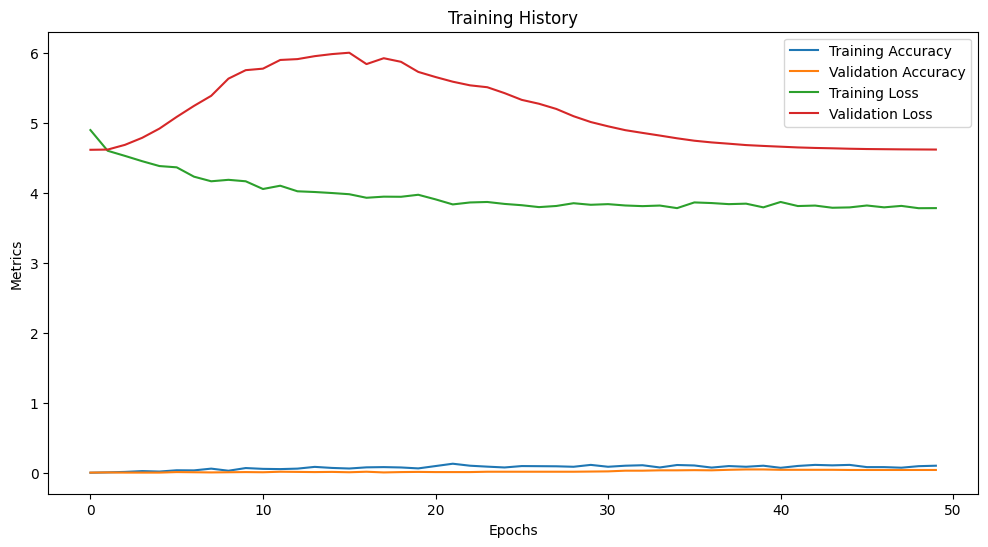

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 960ms/step - accuracy: 0.0600 - loss: 4.6013
Test Loss: 4.6169114112854
Test Accuracy: 0.04749999940395355


In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training History')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


## Saving the model

In [ ]:
# Save the trained model
model.save("simplified_ear_classification_model.h5")
print("Model saved successfully!")


Model saved successfully!
